In [82]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import seaborn as sns
import datetime as dt

In [83]:
def plot_predictions(models):
    """
    models: list of model dicts
    """
    num_plot_elems = len(models)
    fig = plt.figure(figsize=(8,12))
    # get plot position
    plot_locations = range(100*num_plot_elems+11,100*num_plot_elems+11+num_plot_elems)
    for i, plot_location in enumerate(plot_locations):
        model = models[i]
        analyzed_time_bundles = [datetime.strptime(x,TIME_FORMAT) for x in model['analyzed_time_bundle_starts']]
        ax = fig.add_subplot(plot_location)
        ax.plot(analyzed_time_bundles, model['predicted_values'], 'g--')
        ax.plot(analyzed_time_bundles, model['analyzed_data'], 'b-')


In [89]:
# Read data from https://github.com/CSSEGISandData/COVID-19/
conf = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
conf = conf.rename(columns={"Province/State": "state", "Country/Region": "country", "Lat": "lat", "Lon": "lon", "Cases": "cases", "Date": "date"})

# Normalize
conf = pd.melt(conf, id_vars=list(conf.columns[:4]), value_vars = list(conf.columns[4:]), var_name='date', value_name='cases')
conf['date'] = pd.to_datetime(conf['date'])

# Index by date
conf = conf.set_index('date')
conf

# Load state populations
popsdf = pd.read_csv("state_populations.csv")
# next(popsdsf)
pops = {p['NAME']: int(p['POPESTIMATE2019']) for _,p in list(popsdf.iterrows())}
pops

START_DAY =  dt.datetime(year=2020,month=3,day=1)
END_DAY =  dt.datetime.utcnow() + dt.timedelta(days=1)

# Filter date ranges we care about
conf['day'] = (conf.index - START_DAY).days
conf = conf[conf['day'] > 0].copy()
# Grab some interesting states
# maconf = conf[conf['state'].isin(['Massachusetts', 'New York', 'California'])]

us = conf[conf['country'] == 'US'].copy()

# Data until ~03-10 is split by county, which is hella annoying
# First, add the county totals to the state totals
for state, abbrev in [('Massachusetts', 'MA'), ('New York', 'NY'), ('California', 'CA'), ('Washington', 'WA')]:
    us.loc[us['state'].str.contains(abbrev), ['state']] = state
#     county_rows = us[us['Province/State'].str.contains(abbrev)]
#     county_rows['Province/State'] = state
# Remove any lingering county labels
us = us[~us['state'].str.contains(',')]
# Remove princesses
us = us[~us['state'].str.contains('incess')]
# Groupy by state
us = us.groupby(['date', 'day', 'state', 'country']).sum()
us = us.reset_index().set_index('day')

us['cases_per_100k'] = us.apply(lambda c: float(c.cases) * 100000 / pops.get(c.state, 100000), axis=1)

In [90]:

us
# us_simple = us[us['Day'] > 0][['Day', 'Province/State', 'Cases']]
# us[us['Days'] == 4]
# us_simple.set_index('Day')
# us_simple['Province/State'].unique()
scary_states = us.groupby(['state'])['cases_per_100k'].max()
scary_states = list(scary_states[scary_states > 2].copy().index)
scary_states

scary_cases = us[us['state'].isin(scary_states)].copy()
scary_cases


,date,state,country,lat,Long,cases,cases_per_100k
day,,,,,,,
1,2020-03-02,Colorado,US,39.0598,-105.3111,0,0.000000
1,2020-03-02,District of Columbia,US,38.8974,-77.0268,0,0.000000
1,2020-03-02,Guam,US,13.4443,144.7937,0,0.000000
1,2020-03-02,Louisiana,US,31.1695,-91.8678,0,0.000000
1,2020-03-02,Maine,US,44.6939,-69.3819,0,0.000000
...,...,...,...,...,...,...,...
16,2020-03-17,New Jersey,US,40.2989,-74.5210,267,3.006015
16,2020-03-17,New York,US,331.6799,-591.1543,1706,8.769603
16,2020-03-17,Puerto Rico,US,18.2208,-66.5901,5,5.000000


['2020-03-02T00:00:00.000000000' '2020-03-05T00:00:00.000000000'
 '2020-03-08T00:00:00.000000000' '2020-03-11T00:00:00.000000000'
 '2020-03-14T00:00:00.000000000' '2020-03-17T00:00:00.000000000']
['03/02', '03/05', '03/08', '03/11', '03/14', '03/17']


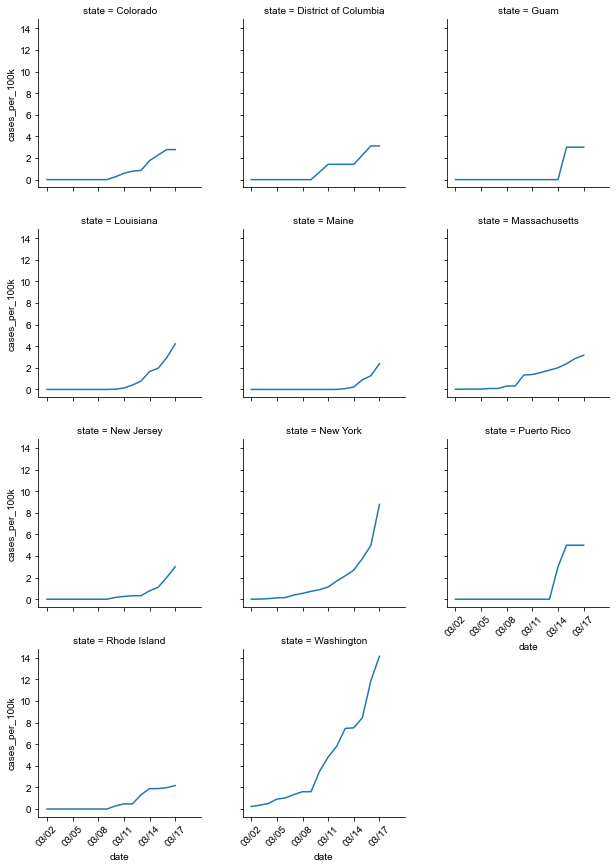

In [91]:
import matplotlib.dates as mdates
date_fmt = mdates.DateFormatter('%m/%d')
def plovid(data):
    sns.reset_orig()
    ax = sns.relplot(data=data.reset_index(), x='date', y='cases_per_100k', col='state',
                     col_wrap=3, kind='line',  ci=None, height=3)
    ax.set(xlim=(START_DAY, END_DAY))
    xticks = np.array(data['date'].unique())[::3]
    print(xticks)
    ax.set(xticks=xticks)
    xlabels = [pd.to_datetime(str(i)).strftime("%m/%d")  for i in xticks]
    print(xlabels)
    ax.set_xticklabels(labels=xlabels, rotation=45)
    sns.set_style("ticks", {"xtick.major.formatter": date_fmt})
    return ax

ax = plovid(scary_cases)


ax.savefig("us.png")


mamelt